In [2]:
import pandas as pd
import sys
assert sys.version_info >= (3, 5) # make sure we have Python 3.5+

from pyspark.sql import SparkSession, functions, types
spark = SparkSession.builder.appName('colour prediction').getOrCreate()
spark.sparkContext.setLogLevel('WARN')
assert spark.version >= '2.4' # make sure we have Spark 2.4+

In [3]:
tmax_schema = types.StructType([
        types.StructField('station', types.StringType()),
        types.StructField('date', types.DateType()),
        types.StructField('latitude', types.FloatType()),
        types.StructField('longitude', types.FloatType()),
        types.StructField('elevation', types.FloatType()),
        types.StructField('tmax', types.FloatType()),
    ])

data = spark.read.csv('./tmax-2', schema=tmax_schema)

In [4]:
# set the configuration for arrwo
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
# convert the spark df to pandas df so that we can plot
df = data.select("*").toPandas()

/Users/zhixuanchi/Desktop/spark-2.4.4-bin-hadoop2.7/python/pyspark/sql/dataframe.py:2103: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


In [5]:
import datetime

startdate = datetime.datetime.strptime('1950-01-01', "%Y-%m-%d").date()

enddate = datetime.datetime.strptime('1980-12-31', "%Y-%m-%d").date()

startdate2 = datetime.datetime.strptime('1981-01-01', "%Y-%m-%d").date()

enddate2 = datetime.datetime.strptime('2010-12-31', "%Y-%m-%d").date()

df_1950_1980 = df[(df['date']>=startdate) & (df['date']<=enddate)]

df_1980_2010 = df[(df['date']>=startdate2) & (df['date']<=enddate2)]

In [6]:
df_1950_1980 = df_1950_1980.groupby(['latitude','longitude', 'date']).agg('mean')
df_1980_2010 = df_1980_2010.groupby(['latitude','longitude', 'date']).agg('mean')

In [7]:
df_1950_1980_average = df_1950_1980.groupby(['latitude','longitude']).agg('mean').reset_index()
df_1980_2010_average = df_1980_2010.groupby(['latitude','longitude']).agg('mean').reset_index()

In [8]:
df_full = df_1950_1980_average.merge(df_1980_2010_average, on=['latitude','longitude'], suffixes=('_period1','_period2'))
df_full['net_change'] = df_full['tmax_period2']-df_full['tmax_period1']

In [9]:
df_full = df_full[['latitude','longitude','net_change']]

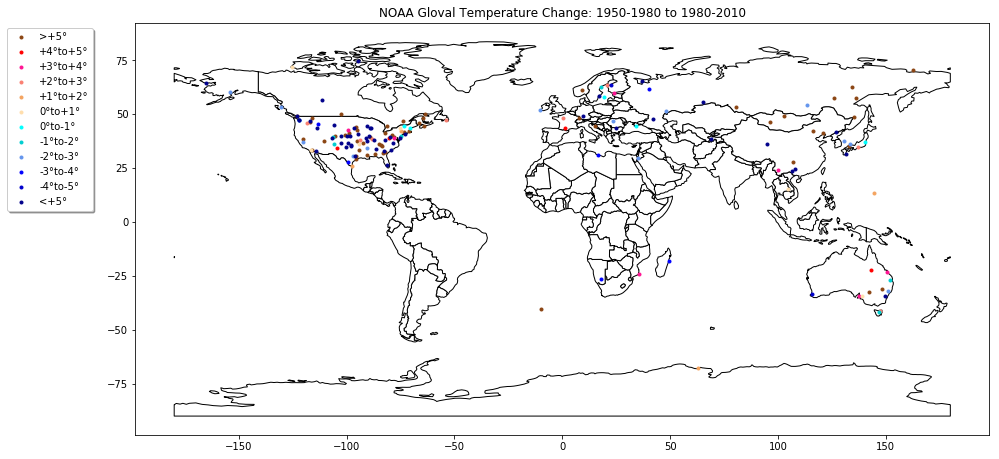

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt

# create a GeoDataFrame rom a DataFrame with longitudes and latitudes
gdf = gpd.GeoDataFrame(df_full, geometry=gpd.points_from_xy(df_full.longitude, df_full.latitude))

fig, ax = plt.subplots(figsize=(17,10))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='white', edgecolor='black')
gdf[gdf['net_change']>5].plot(ax=ax,color='saddlebrown',label='>+5'+ chr(176),marker='.')
gdf[(gdf['net_change']>=4) & (gdf['net_change']<=5) ].plot(ax=ax,color='red',label='+4'+ chr(176)+'to'+'+5'+ chr(176),marker='.')
gdf[(gdf['net_change']>=3) & (gdf['net_change']<=4) ].plot(ax=ax,color='deeppink',label='+3'+ chr(176)+'to'+'+4'+ chr(176),marker='.')
gdf[(gdf['net_change']>=2) & (gdf['net_change']<=3) ].plot(ax=ax,color='salmon',label='+2'+ chr(176)+'to'+'+3'+ chr(176),marker='.')
gdf[(gdf['net_change']>=1) & (gdf['net_change']<=2) ].plot(ax=ax,color='sandybrown',label='+1'+ chr(176)+'to'+'+2'+ chr(176),marker='.')
gdf[(gdf['net_change']>=0) & (gdf['net_change']<=1) ].plot(ax=ax,color='navajowhite',label='0'+ chr(176)+'to'+'+1'+ chr(176),marker='.')
gdf[(gdf['net_change']>=-1) & (gdf['net_change']<=0) ].plot(ax=ax,color='aqua',label='0'+ chr(176)+'to'+'-1'+ chr(176),marker='.')
gdf[(gdf['net_change']>=-2) & (gdf['net_change']<=-1) ].plot(ax=ax,color='darkturquoise',label='-1'+ chr(176)+'to'+'-2'+ chr(176),marker='.')
gdf[(gdf['net_change']>=-3) & (gdf['net_change']<=-2) ].plot(ax=ax,color='cornflowerblue',label='-2'+ chr(176)+'to'+'-3'+ chr(176),marker='.')
gdf[(gdf['net_change']>=-4) & (gdf['net_change']<=-3) ].plot(ax=ax,color='blue',label='-3'+ chr(176)+'to'+'-4'+ chr(176),marker='.')
gdf[(gdf['net_change']>=-5) & (gdf['net_change']<=-4) ].plot(ax=ax,color='mediumblue',label='-4'+ chr(176)+'to'+'-5'+ chr(176),marker='.')
gdf[gdf['net_change']<=-5].plot(ax=ax,color='darkblue',label='<+5'+ chr(176),marker='.')
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.9, chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(-0.1, 1), shadow=True, ncol=1)
plt.title('NOAA Gloval Temperature Change: 1950-1980 to 1980-2010')
plt.show()